# Telco Churn Prediction using XGBoost Model

**Objective:** Build and evaluate churn prediction models (Logistic Regression, Random Forest as baselines) and finalize with **XGBoost** as the production-ready model.

## 1. Import Libraries

In [149]:

# For Data manipulation and numerical computing
import pandas as pd        # For handling dataframes and structured data
import numpy as np         # For numerical operations and arrays

# For Data visualization
import matplotlib.pyplot as plt   # For creating plots and charts
import seaborn as sns             # For advanced statistical visualizations

# For Model selection and evaluation
from sklearn.model_selection import (
    train_test_split,        # Split data into training and test sets
    StratifiedKFold,         # Cross-validation strategy maintaining class proportions
    RandomizedSearchCV       # Hyperparameter tuning using randomized search
)

# For Preprocessing
from sklearn.preprocessing import (
    LabelEncoder,            # Encode categorical labels as integers
    OneHotEncoder,           # Encode categorical variables as one-hot vectors
    StandardScaler           # Scale numerical features to have mean=0, std=1
)
from sklearn.impute import SimpleImputer  # Handle missing values in datasets
from sklearn.pipeline import Pipeline      # Combine preprocessing and modeling steps
from sklearn.compose import ColumnTransformer  # Apply different transformations to different columns

#For Metrics and model evaluation
from sklearn.metrics import (
    accuracy_score,          # Evaluate overall accuracy
    precision_score,         # Evaluate precision 
    recall_score,            # Evaluate recall 
    f1_score,                # Harmonic mean of precision and recall
    roc_auc_score,           # Area under ROC curve
    confusion_matrix,        # Confusion matrix for classification
    classification_report,   # Detailed classification metrics
    RocCurveDisplay          # Plot ROC curve
)

# For Machine learning models
from sklearn.linear_model import LogisticRegression  # Baseline classifier
from sklearn.ensemble import RandomForestClassifier  # Ensemble-based classifier
import xgboost as xgb                                # Gradient boosting classifier

# For Model persistence
import joblib  # Save and load trained models

# For Warnings
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for clean output



## 2. Load and Explore Dataset

In [151]:
# Load dataset
df = pd.read_csv('telco_integrated_dataset.csv')

df.head()

,Customer ID,Gender,Age,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,City,...,CLTV,Churn,Tenure Category,Age Group,ARPU,Payment Consistency,Service Bundling Score,Complaint Frequency,Engagement Index,Senior Flag
0,8779-QRDMV,Male,78,Yes,No,No,0,United States,California,Los Angeles,...,5433,1,0-1 Year,61+,59.650000,1.504414,2,0,10,1
1,7495-OOKFY,Female,74,Yes,Yes,Yes,1,United States,California,Los Angeles,...,5302,1,0-1 Year,61+,128.012500,1.587260,1,1,18,1
2,1658-BYGOY,Male,71,Yes,No,Yes,3,United States,California,Los Angeles,...,3179,1,1-2 Years,61+,106.160000,1.112205,3,0,55,1
3,4598-XLKNJ,Female,78,Yes,Yes,Yes,1,United States,California,Inglewood,...,5337,1,2-3 Years,61+,119.802800,1.216272,4,1,16,1
4,4846-WHAFZ,Female,80,Yes,Yes,Yes,1,United States,California,Whittier,...,2793,1,3+ Years,61+,83.847568,1.096047,0,1,14,1


In [152]:
# Display basic information
print("Dataset Shape:", df.shape)

Dataset Shape: (7043, 56)


In [153]:
# Check if all missing values are handled
print("\nMissing Values Before Handling:")
print(df.isnull().sum().sum())


Missing Values Before Handling:
0


In [154]:
# Check Churn Statistics 
df["Churn"].value_counts() #5174 customers have not Churned while 1869 customers have churned

Churn
0    5174
1    1869
Name: count, dtype: int64

TARGET VARIABLE DISTRIBUTION
Non-Churned Customers: 5174 (73.46%)
Churned Customers: 1869 (26.54%)


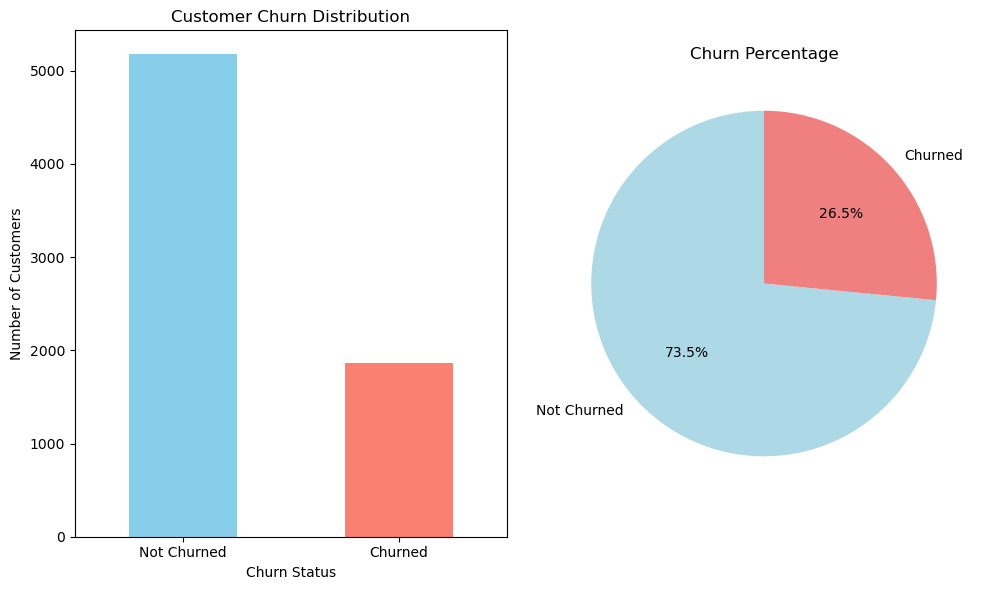


Churn Rate: 26.54%


In [155]:
# TARGET VARIABLE ANALYSIS

print("TARGET VARIABLE DISTRIBUTION")
print("="*50)

# To calculate churn counts and percentages
# churn_counts: number of customers who churned (1) vs those who did not churn (0)
# churn_percentage: percentage of churned vs non-churned customers
churn_counts = df['Churn'].value_counts()
churn_percentage = df['Churn'].value_counts(normalize=True) * 100

# Print churn distribution in numbers and percentages
print(f"Non-Churned Customers: {churn_counts[0]} ({churn_percentage[0]:.2f}%)")
print(f"Churned Customers: {churn_counts[1]} ({churn_percentage[1]:.2f}%)")

# Visualize churn distribution using bar chart and pie chart
plt.figure(figsize=(10, 6))

# Bar chart: shows the number of churned vs non-churned customers
plt.subplot(1, 2, 1)
churn_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Customer Churn Distribution')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.xticks(ticks=[0, 1], labels=['Not Churned', 'Churned'], rotation=0)

# Pie chart: shows the percentage of churned vs non-churned customers
plt.subplot(1, 2, 2)
plt.pie(churn_counts, labels=['Not Churned', 'Churned'], autopct='%1.1f%%', 
        colors=['lightblue', 'lightcoral'], startangle=90)
plt.title('Churn Percentage')

# Adjust layout so charts don't overlap
plt.tight_layout()
plt.show()

# Print overall churn rate for reference
print(f"\nChurn Rate: {churn_percentage[1]:.2f}%")


## 3. Data preparation - splitting the dataset(training-testing)

### 3a. Check Datatypes

In [158]:
# Check the different data types to determine column classification
print(df.dtypes)

Customer ID                     object
Gender                          object
Age                              int64
Senior Citizen                  object
Married                         object
Dependents                      object
Number of Dependents             int64
Country                         object
State                           object
City                            object
Zip Code                         int64
Latitude                       float64
Longitude                      float64
Population                       int64
Monthly Charge                 float64
Total Charges                  float64
Total Revenue                  float64
Total Refunds                  float64
Total Extra Data Charges         int64
Total Long Distance Charges    float64
Payment Method                  object
Paperless Billing               object
Phone Service                   object
Multiple Lines                  object
Internet Service                object
Internet Type            

In [159]:
# Define target and drop leakage columns
target_col = 'Churn'

drop_cols = [
    'Customer ID',
    'Customer Status',
    'Churn Label',
    'Churn Reason',
    'Churn Category',
    'Churn Score'
]

In [160]:
# Features used for model training (all columns except the target and  columns dropped)
X = df.drop(drop_cols + [target_col], axis=1)

# Target variable to be predicted ('Churn')
y = df[target_col]

### 3b. Numerical Columns (for StandardScaler or direct use)
#### These are continuous/discrete numeric features

In [162]:
numeric_cols = [
    'Age','Number of Dependents','Latitude','Longitude','Population',
    'Monthly Charge','Total Charges','Total Revenue','Total Refunds',
    'Total Extra Data Charges','Total Long Distance Charges','Avg Monthly GB Download',
    'Number of Referrals','Satisfaction Score','CLTV','ARPU',
    'Payment Consistency','Service Bundling Score','Complaint Frequency',
    'Engagement Index','Senior Flag','Tenure in Months'
]

### 3c. Categorical Columns (for OneHotEncoder)
#### These are text/label features describing customers/service

In [164]:
categorical_cols = [
    'Gender', 'Senior Citizen','Married','Dependents','Country','State','City','Zip Code',
    'Payment Method','Paperless Billing','Phone Service','Multiple Lines',
    'Internet Service','Internet Type','Online Security','Online Backup',
    'Device Protection Plan','Premium Tech Support','Streaming TV',
    'Streaming Movies','Streaming Music','Unlimited Data','Contract','Offer',
    'Referred a Friend','Tenure Category','Age Group'
]

In [165]:
# PREPROCESSING PIPELINES

# Pipeline for numeric features
# Applies StandardScaler to scale numerical features to have mean=0 and std=1
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
# Applies OneHotEncoder to convert categorical variables into binary/dummy variables
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer to apply transformations to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),         # 'num' transformer is applied to numeric columns
        ('cat', categorical_transformer, categorical_cols)  # 'cat' transformer is applied to categorical columns
    ]
)

In [166]:
numeric_transformer

Pipeline(steps=[('scaler', StandardScaler())])

In [167]:
categorical_transformer

Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

In [168]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Age', 'Number of Dependents', 'Latitude',
                                  'Longitude', 'Population', 'Monthly Charge',
                                  'Total Charges', 'Total Revenue',
                                  'Total Refunds', 'Total Extra Data Charges',
                                  'Total Long Distance Charges',
                                  'Avg Monthly GB Download',
                                  'Number of Referrals', 'Satisfaction Score',
                                  'CLTV', 'ARPU', 'Payment Cons...
                                  'Dependents', 'Country', 'State', 'City',
                                  'Zip Code', 'Payment Method',
                                  'Paperless Billing', 'Phone Service',
                                  'Multiple Lines', 'Internet Service',
                                  'Internet Type', 'Online Security',
                                  'Online Backup', 'Device Protection Plan',
                                  'Premium Tech Support', 'Streaming TV',
                                  'Streaming Movies', 'Streaming Music',
                                  'Unlimited Data', 'Contract', 'Offer',
                                  'Referred a Friend', 'Tenure Category',
                                  'Age Group'])])

In [169]:
# Split dataset - Train/test split (stratified)
X_full = X.copy()
y_full = y.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, 
    test_size=0.2,          # 20% test data, 80% training
    stratify=y_full,        # keep same churn ratio in train/test
    random_state=42         # reproducible split
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training churn rate: {y_train.mean():.3f}")
print(f"Test churn rate: {y_test.mean():.3f}")

Training set shape: (5634, 49)
Test set shape: (1409, 49)
Training churn rate: 0.265
Test churn rate: 0.265


In [170]:
# Fit the transformer  
numeric_transformer.fit(X_train[numeric_cols])

# Check the scaler attributes
scaler = numeric_transformer.named_steps['scaler']
print("Mean:", scaler.mean_)
print("Scale:", scaler.scale_)
print("Feature names:", scaler.feature_names_in_)

Mean: [ 4.65516507e+01  4.68051118e-01  3.62059730e+01 -1.19768305e+02
  2.20447242e+04  6.48910277e+01  2.28929844e+03  3.04772610e+03
  1.95746006e+00  6.72523962e+00  7.53659881e+02  2.05186368e+01
  1.96450124e+00  3.24689386e+00  4.40185463e+03  8.82491081e+01
  1.49102710e+00  2.40770323e+00  1.96450124e+00  2.29263401e+01
  1.65779198e-01  3.25079872e+01]
Scale: [1.68033346e+01 9.67409028e-01 2.47091988e+00 2.15114189e+00
 2.11371355e+04 3.01279352e+01 2.27235598e+03 2.87182493e+03
 7.83976608e+00 2.48191208e+01 8.46407210e+02 2.03996220e+01
 3.01036254e+00 1.20506347e+00 1.19038383e+03 3.59591277e+01
 5.28019648e-01 2.17345564e+00 3.01036254e+00 2.12918194e+01
 3.71882314e-01 2.46268645e+01]
Feature names: ['Age' 'Number of Dependents' 'Latitude' 'Longitude' 'Population'
 'Monthly Charge' 'Total Charges' 'Total Revenue' 'Total Refunds'
 'Total Extra Data Charges' 'Total Long Distance Charges'
 'Avg Monthly GB Download' 'Number of Referrals' 'Satisfaction Score'
 'CLTV' 'ARPU' '

## 4. Building the Prediction Model

### 4a. Logistic Regression baseline

In [173]:
# Explicit baseline model
log_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Basic preprocessing only
    ('classifier', LogisticRegression(max_iter=1000))  # Minimal custom parameters
])

print("Training baseline model...")
log_baseline.fit(X_train, y_train)


Training baseline model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age',
                                                   'Number of Dependents',
                                                   'Latitude', 'Longitude',
                                                   'Population',
                                                   'Monthly Charge',
                                                   'Total Charges',
                                                   'Total Revenue',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Number of Referrals',
                                                   'Satisfactio...
                                                   'Zip Code', 'Payment Method',
                                                   'Paperless Billing',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Internet Type',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection Plan',
                                                   'Premium Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Streaming Music',
                                                   'Unlimited Data', 'Contract',
                                                   'Offer', 'Referred a Friend',
                                                   'Tenure Category',
                                                   'Age Group'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1035
           1       0.91      0.93      0.92       374

    accuracy                           0.96      1409
   macro avg       0.94      0.95      0.94      1409
weighted avg       0.96      0.96      0.96      1409


Additional Metrics:
Accuracy: 0.9567
ROC-AUC Score: 0.9913

Confusion Matrix:
[[1001   34]
 [  27  347]]


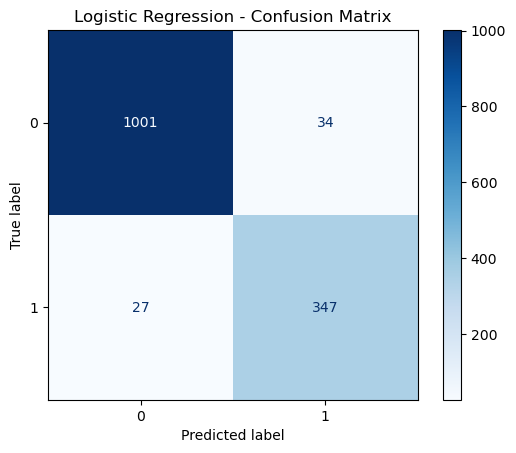

In [174]:

# Imports needed for metrics visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Create a pipeline combining preprocessing and logistic regression
log_pipe = Pipeline(steps=[
    ('pre', preprocessor), 
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Train the pipeline on training data
log_pipe.fit(X_train, y_train)

# Make predictions and probability estimates for the positive class
y_pred_log = log_pipe.predict(X_test)
y_pred_log_proba = log_pipe.predict_proba(X_test)[:, 1]

# Classification report
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_log))

# Additional metrics
print("\n" + "="*50)
print("Additional Metrics:")
print("="*50)
accuracy = accuracy_score(y_test, y_pred_log)
roc_auc = roc_auc_score(y_test, y_pred_log_proba)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Confusion matrix and visualization
cm = confusion_matrix(y_test, y_pred_log)
print(f"\nConfusion Matrix:\n{cm}")

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_pipe.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Logistic Regression - Confusion Matrix')
plt.grid(False)
plt.show()


### 4b. Random Forest baseline

In [176]:
# Explicit baseline model - Random Forest
rf_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Basic preprocessing only
    ('classifier', RandomForestClassifier(random_state=42))  # Minimal custom parameters, only random_state for reproducibility
])

print("Training Random Forest baseline model...")
rf_baseline.fit(X_train, y_train)

Training Random Forest baseline model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age',
                                                   'Number of Dependents',
                                                   'Latitude', 'Longitude',
                                                   'Population',
                                                   'Monthly Charge',
                                                   'Total Charges',
                                                   'Total Revenue',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Number of Referrals',
                                                   'Satisfactio...
                                                   'Paperless Billing',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Internet Type',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection Plan',
                                                   'Premium Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Streaming Music',
                                                   'Unlimited Data', 'Contract',
                                                   'Offer', 'Referred a Friend',
                                                   'Tenure Category',
                                                   'Age Group'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Random Forest Baseline Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1035
           1       0.94      0.77      0.85       374

    accuracy                           0.93      1409
   macro avg       0.93      0.88      0.90      1409
weighted avg       0.93      0.93      0.92      1409


Random Forest Baseline - Additional Metrics:
Accuracy: 0.9255
ROC-AUC Score: 0.9664

Confusion Matrix:
[[1015   20]
 [  85  289]]


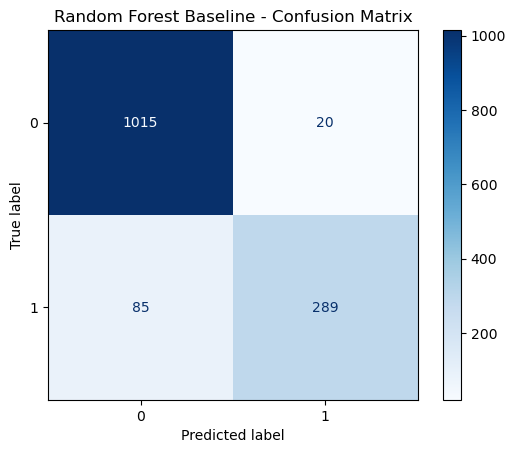

In [177]:
# Make predictions
y_pred_rf = rf_baseline.predict(X_test)
y_pred_rf_proba = rf_baseline.predict_proba(X_test)[:, 1]

# Generate and display classification report
print("Random Forest Baseline Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

# Additional metrics for comprehensive evaluation
print("\n" + "="*50)
print("Random Forest Baseline - Additional Metrics:")
print("="*50)

# Calculate and display accuracy
from sklearn.metrics import accuracy_score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.4f}")

# Calculate and display ROC-AUC score
from sklearn.metrics import roc_auc_score
roc_auc_rf = roc_auc_score(y_test, y_pred_rf_proba)
print(f"ROC-AUC Score: {roc_auc_rf:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(f"\nConfusion Matrix:")
print(cm_rf)

# Create and display only the confusion matrix visualization
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, 
                              display_labels=rf_baseline.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Random Forest Baseline - Confusion Matrix')
plt.grid(False)
plt.show()


###  4c. Model training with XGBoost

In [179]:
from xgboost import XGBClassifier

# Main model - XGBoost pipeline using XGBClassifier
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Same preprocessing pipeline
    ('classifier', XGBClassifier(random_state=42))  # XGBoost with random_state for reproducibility
])

print("Training XGBoost model...")
xgb_pipe.fit(X_train, y_train)

Training XGBoost model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age',
                                                   'Number of Dependents',
                                                   'Latitude', 'Longitude',
                                                   'Population',
                                                   'Monthly Charge',
                                                   'Total Charges',
                                                   'Total Revenue',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Number of Referrals',
                                                   'Satisfactio...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

Training XGBoost main model...
XGBoost Main Model Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1035
           1       0.96      0.90      0.93       374

    accuracy                           0.96      1409
   macro avg       0.96      0.94      0.95      1409
weighted avg       0.96      0.96      0.96      1409


XGBoost Main Model - Additional Metrics:
Accuracy: 0.9638
ROC-AUC Score: 0.9925

Confusion Matrix:
[[1022   13]
 [  38  336]]


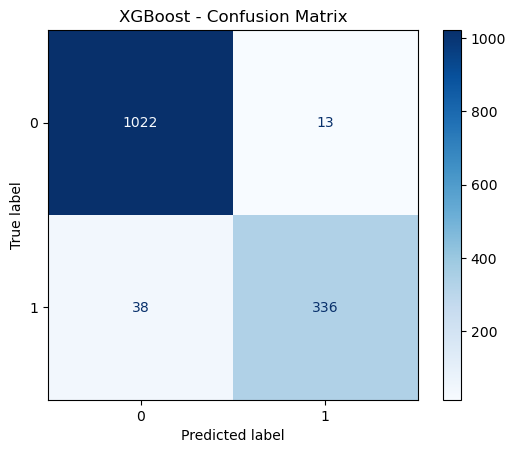

In [180]:

# Main model - XGBoost pipeline with careful parameter selection
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Same preprocessing as baseline models
    ('classifier', XGBClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
    ))
])

print("Training XGBoost main model...")
xgb_pipe.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_pipe.predict(X_test)
y_pred_xgb_proba = xgb_pipe.predict_proba(X_test)[:, 1]

# Generate and display classification report
print("XGBoost Main Model Classification Report:\n")
print(classification_report(y_test, y_pred_xgb))

# Additional metrics for comprehensive evaluation
print("\n" + "="*50)
print("XGBoost Main Model - Additional Metrics:")
print("="*50)

# Calculate and display accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy_xgb:.4f}")

# Calculate and display ROC-AUC score
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb_proba)
print(f"ROC-AUC Score: {roc_auc_xgb:.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(f"\nConfusion Matrix:")
print(cm_xgb)

# Create and display the confusion matrix visualization
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, 
                              display_labels=xgb_pipe.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('XGBoost - Confusion Matrix')
plt.grid(False)
plt.show()

## 5. Evaluating and comparing the models performances using relevant metrics

### 5a. Accuracy and  ROC Curve & AUC  to Measures the proportion of correct predictions.

In [183]:
# Comparison of all models

print("MODEL COMPARISON SUMMARY")
print("="*60)

# Dictionary of models with their predictions and predicted probabilities
models = {
    'Logistic Regression Baseline': (y_pred_log, y_pred_log_proba),
    'Random Forest Baseline      ': (y_pred_rf, y_pred_rf_proba),
    'XGBoost Main Model          ': (y_pred_xgb, y_pred_xgb_proba)
}

# Print table header
print(f"{'Model':<25} {'Accuracy':<10} {'ROC-AUC':<10}")
print("-" * 50)

# Iterate through each model, calculate accuracy and ROC-AUC, and print results
for model_name, (y_pred, y_proba) in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"{model_name:<25} {accuracy:.4f}    {roc_auc:.4f}")


MODEL COMPARISON SUMMARY
Model                     Accuracy   ROC-AUC   
--------------------------------------------------
Logistic Regression Baseline 0.9567    0.9913
Random Forest Baseline       0.9255    0.9664
XGBoost Main Model           0.9638    0.9925


### 5b. Precision, Recall, and F1-Score
Precision: Of all customers predicted as churn, how many actually churned?

Recall (Sensitivity): Of all customers who churned, how many did we correctly identify?

F1-Score: Balance between precision and recall.

In [185]:

# Ensures predictions are available from all three models
y_pred_log = log_baseline.predict(X_test)   # Logistic Regression predictions
y_pred_rf = rf_baseline.predict(X_test)     # Random Forest predictions
y_pred_xgb = xgb_pipe.predict(X_test)       # XGBoost predictions

# Dictionary of models and their predictions
models = {
    'Logistic Regression Baseline': y_pred_log,
    'Random Forest Baseline': y_pred_rf,
    'XGBoost Main Model': y_pred_xgb
}

# Calculate performance metrics for each model
comparison_data = []
for model_name, y_pred in models.items():
    precision = precision_score(y_test, y_pred)  # Precision = TP / (TP + FP)
    recall = recall_score(y_test, y_pred)        # Recall = TP / (TP + FN)
    f1 = f1_score(y_test, y_pred)               # F1-Score = harmonic mean of precision and recall
    accuracy = accuracy_score(y_test, y_pred)   # Accuracy = (TP + TN) / Total
    
    # Append metrics to list for DataFrame creation
    comparison_data.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy
    })

# Creates a DataFrame summarizing all model metrics
comparison_df = pd.DataFrame(comparison_data)

# Displays the metrics comparison table

print("MODEL COMPARISON SUMMARY")
print("="*70)
print(comparison_df.round(4))

# Identifies and displays the best performing model for each metric
print("\n" + "="*70)
print("BEST PERFORMING MODELS BY METRIC")
print("="*70)
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
for metric in metrics:
    best_model = comparison_df.loc[comparison_df[metric].idxmax(), 'Model']
    best_score = comparison_df[metric].max()
    print(f"{metric}: {best_model} ({best_score:.4f})")


MODEL COMPARISON SUMMARY
                          Model  Precision  Recall  F1-Score  Accuracy
0  Logistic Regression Baseline     0.9517  0.8957    0.9229    0.9603
1        Random Forest Baseline     0.9353  0.7727    0.8463    0.9255
2            XGBoost Main Model     0.9628  0.8984    0.9295    0.9638

BEST PERFORMING MODELS BY METRIC
Precision: XGBoost Main Model (0.9628)
Recall: XGBoost Main Model (0.8984)
F1-Score: XGBoost Main Model (0.9295)
Accuracy: XGBoost Main Model (0.9638)


### 5c. Visualisation

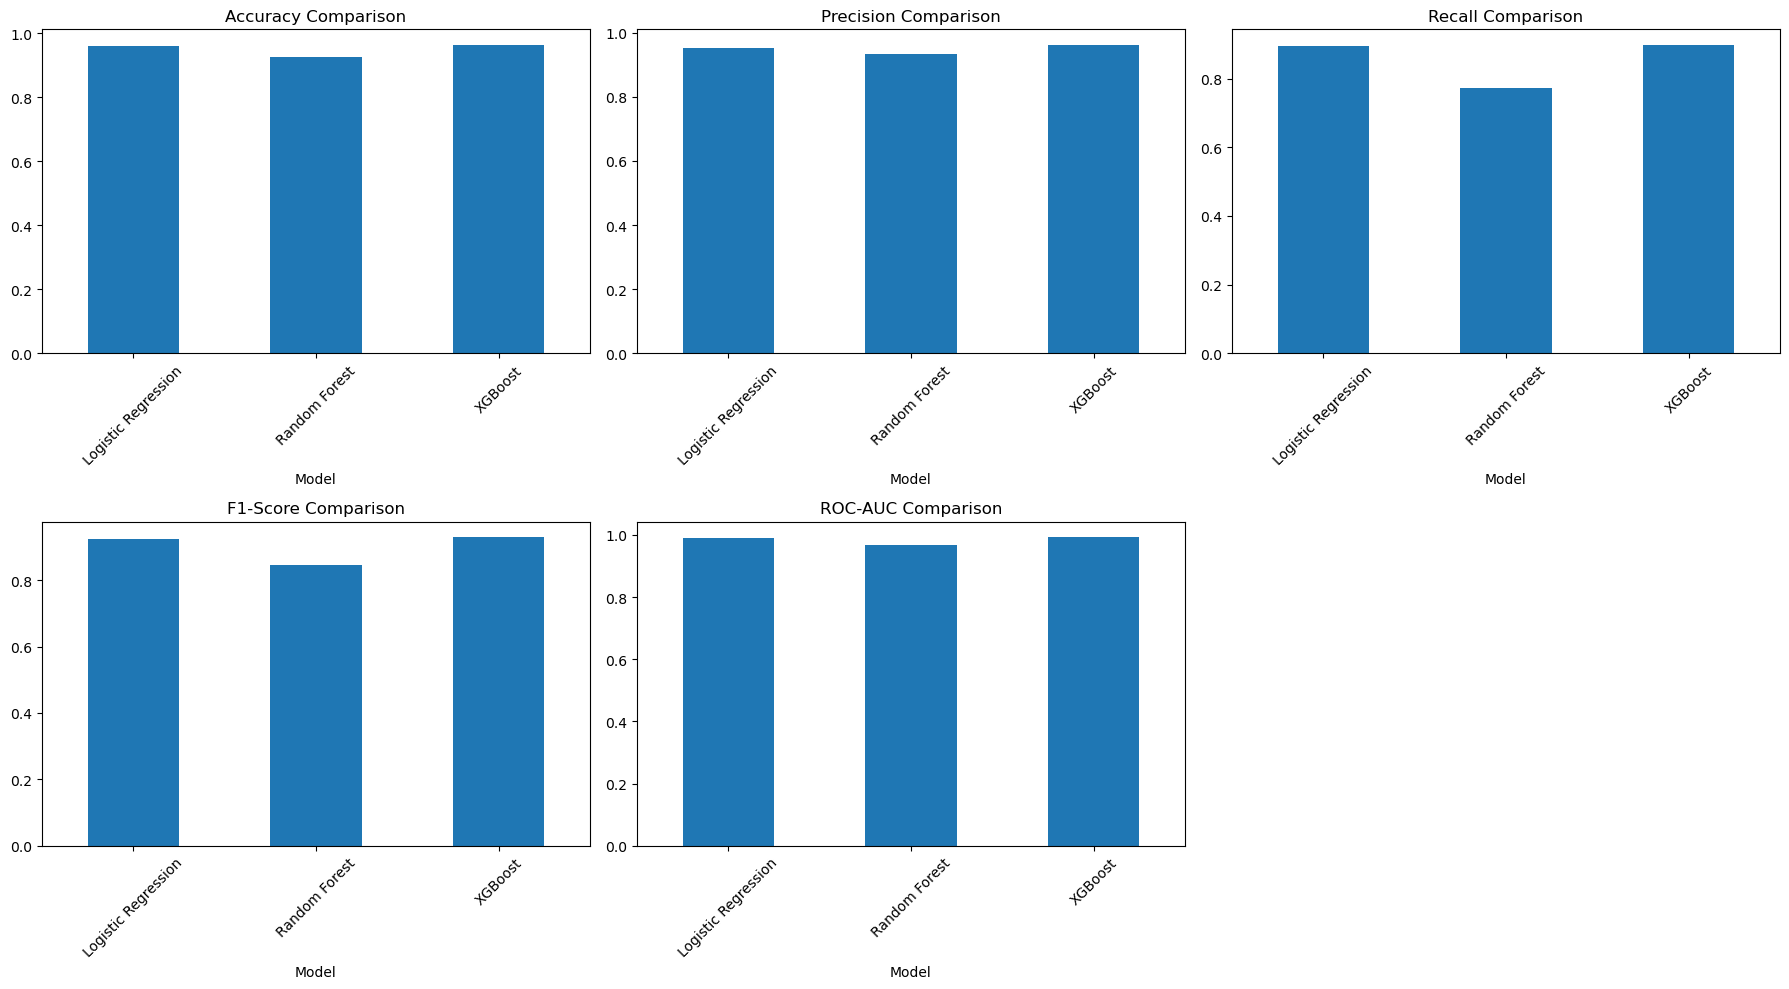

In [187]:
# Visual comparison

# Create a list of dictionaries containing performance metrics for each model
comparison_data = [
    {
        'Model': 'Logistic Regression',
        'Accuracy': accuracy_score(y_test, y_pred_log),
        'Precision': precision_score(y_test, y_pred_log),
        'Recall': recall_score(y_test, y_pred_log),
        'F1-Score': f1_score(y_test, y_pred_log),
        'ROC-AUC': roc_auc_score(y_test, y_pred_log_proba)
    },
    {
        'Model': 'Random Forest',
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Precision': precision_score(y_test, y_pred_rf),
        'Recall': recall_score(y_test, y_pred_rf),
        'F1-Score': f1_score(y_test, y_pred_rf),
        'ROC-AUC': roc_auc_score(y_test, y_pred_rf_proba)
    },
    {
        'Model': 'XGBoost',
        'Accuracy': accuracy_score(y_test, y_pred_xgb),
        'Precision': precision_score(y_test, y_pred_xgb),
        'Recall': recall_score(y_test, y_pred_xgb),
        'F1-Score': f1_score(y_test, y_pred_xgb),
        'ROC-AUC': roc_auc_score(y_test, y_pred_xgb_proba)
    }
]

# Convert the metrics list into a DataFrame for easier visualization
comparison_df = pd.DataFrame(comparison_data)


# Bar Charts for Metrics

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# Create subplots: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()  # Flatten the axes array for easy iteration

# Plot bar charts for each metric
for i, metric in enumerate(metrics):
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=axes[i],
                       title=f'{metric} Comparison', legend=False)
    axes[i].tick_params(axis='x', rotation=45)

# Leaves the last subplot blank (no data)
axes[5].axis("off")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



## 6. Evaluating the XGBoost model performance using relevant metrics

### 6a. ROC curve to evaluate how well the XGBoost model distinguishes between classes, showing its performance against random guessing.

XGBoost Pipeline AUC: 0.9925


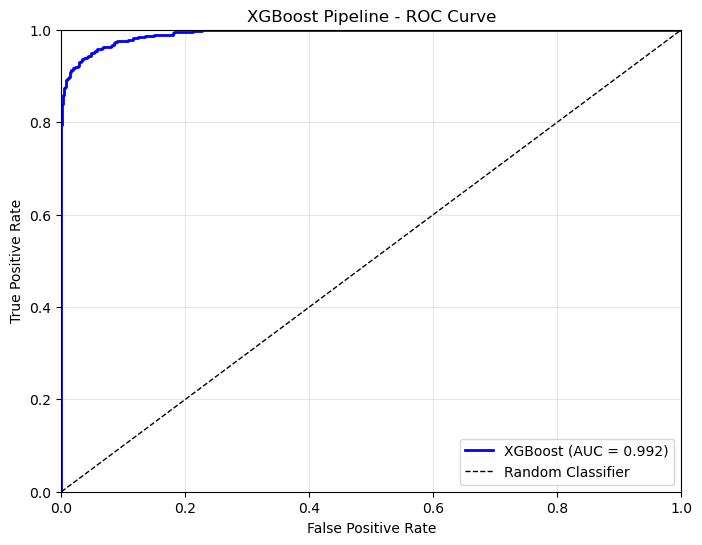


AUC Score Interpretation: 0.9925
Excellent discrimination


In [190]:
# Required imports
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class from your XGBoost pipeline
y_pred_proba = xgb_pipe.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print("XGBoost Pipeline AUC:", round(auc, 4))

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f"XGBoost (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label="Random Classifier")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost Pipeline - ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

# Interpretation of AUC score
print(f"\nAUC Score Interpretation: {auc:.4f}")
if auc == 1.0:
    print("Perfect classifier!")
elif auc >= 0.9:
    print("Excellent discrimination")
elif auc >= 0.8:
    print("Good discrimination") 
elif auc >= 0.7:
    print("Fair discrimination")
elif auc >= 0.6:
    print("Poor discrimination")
else:
    print("No discrimination")


### 6b. Confusion Matrix
Shows True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN).

<Figure size 800x600 with 0 Axes>

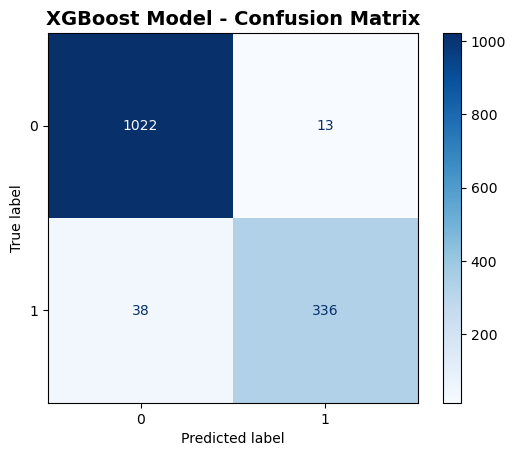

XGBoost Pipeline - Detailed Confusion Analysis:
True Negatives (TN):  1022 - Correctly predicted negative class
False Positives (FP):   13 - Negative class predicted as positive
False Negatives (FN):   38 - Positive class predicted as negative
True Positives (TP):   336 - Correctly predicted positive class


In [192]:
# Create visual confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, 
                              display_labels=xgb_pipe.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('XGBoost Model - Confusion Matrix', fontsize=14, fontweight='bold')
plt.grid(False)
plt.show()

# Detailed confusion matrix with derived metrics
def detailed_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"{model_name} - Detailed Confusion Analysis:")
    print("=" * 50)
    print(f"True Negatives (TN):  {tn:>4} - Correctly predicted negative class")
    print(f"False Positives (FP): {fp:>4} - Negative class predicted as positive")
    print(f"False Negatives (FN): {fn:>4} - Positive class predicted as negative")
    print(f"True Positives (TP):  {tp:>4} - Correctly predicted positive class")
    print("=" * 50)

# Use the function
detailed_confusion_matrix(y_test, y_pred_xgb, "XGBoost Pipeline")

### 6c. Feature Importance Analysis using SHAP Analysis

In [194]:
!pip install shap
!pip install shap matplotlib scikit-learn


Top 20 Most Important Features:
                         Feature  Importance
13            Satisfaction Score    0.226704
2787     Contract_Month-to-Month    0.182185
18           Complaint Frequency    0.057437
2771          Online Security_No    0.053949
2772         Online Security_Yes    0.037514
28                 Dependents_No    0.029093
21              Tenure in Months    0.027333
12           Number of Referrals    0.025828
2780            Streaming TV_Yes    0.024926
5                 Monthly Charge    0.023548
0                            Age    0.022772
2758  Payment Method_Credit Card    0.020528
2761       Paperless Billing_Yes    0.019154
1           Number of Dependents    0.016119
884               City_San Diego    0.014345
2789           Contract_Two Year    0.013480
11       Avg Monthly GB Download    0.012586
17        Service Bundling Score    0.010642
19              Engagement Index    0.010427
7                  Total Revenue    0.009588

Generating SHAP plots.

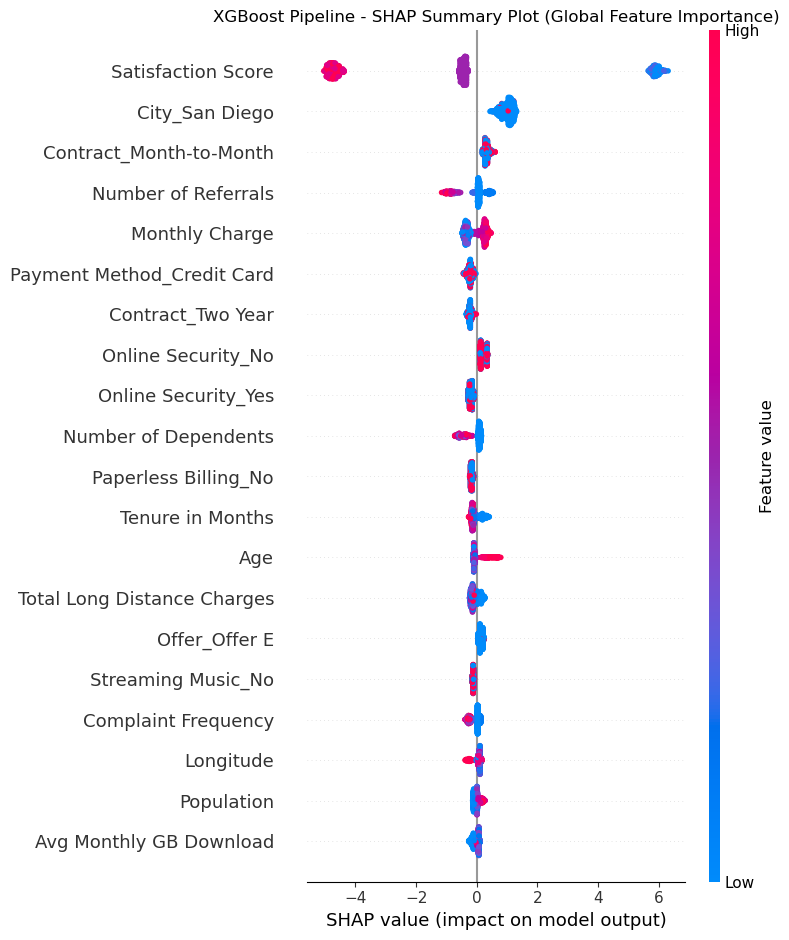


Creating dependence plot for top feature: Satisfaction Score


<Figure size 1000x600 with 0 Axes>

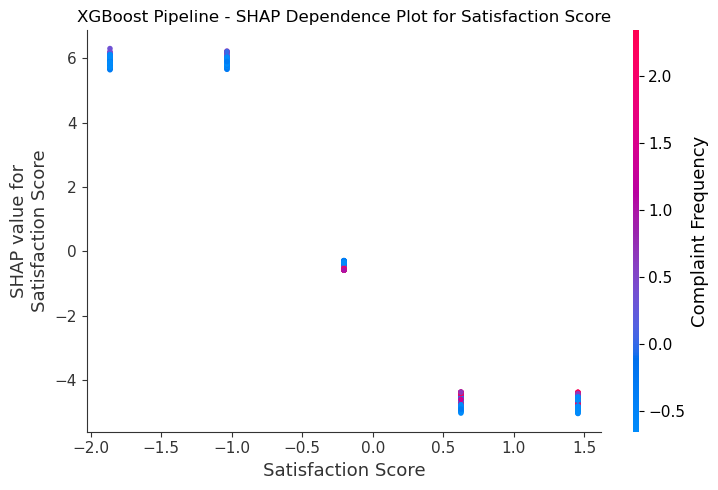


SHAP analysis completed and plots saved!


<Figure size 1000x600 with 0 Axes>

In [195]:
import shap

# Get categorical feature names from OneHotEncoder in your pipeline
cat_features = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)

# Combine numeric and categorical transformed names
all_features = np.concatenate([numeric_cols, cat_features])

# Get feature importances from trained XGBoost pipeline
# Access the XGBoost model from within the pipeline
importances = xgb_pipe.named_steps['classifier'].feature_importances_

# Put into dataframe
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Top 20 Most Important Features:")
print("=" * 50)
print(importance_df.head(20))  # Top 20 features

# SHAP Analysis
print("\nGenerating SHAP plots...")

# Use TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb_pipe.named_steps['classifier'])

# Transform the test data using the preprocessor from your pipeline
X_test_transformed = xgb_pipe.named_steps['preprocessor'].transform(X_test)

# Convert to dense if it's sparse
if hasattr(X_test_transformed, "toarray"):
    X_test_for_shap = X_test_transformed.toarray()
else:
    X_test_for_shap = X_test_transformed

# Compute SHAP values
shap_values = explainer.shap_values(X_test_for_shap)

# Global feature importance (summary plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_for_shap, feature_names=all_features, show=False)
plt.title("XGBoost Pipeline - SHAP Summary Plot (Global Feature Importance)")
plt.tight_layout()
plt.show()

# Dependence plot for top feature (using the actual top feature from importance_df)
top_feature = importance_df.iloc[0]['Feature']
print(f"\nCreating dependence plot for top feature: {top_feature}")

plt.figure(figsize=(10, 6))
shap.dependence_plot(top_feature, shap_values, X_test_for_shap, feature_names=all_features, show=False)
plt.title(f"XGBoost Pipeline - SHAP Dependence Plot for {top_feature}")
plt.tight_layout()
plt.show()

# --- Save SHAP summary plot ---
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_for_shap, feature_names=all_features, show=False)  
plt.title("XGBoost Pipeline - SHAP Summary Plot")
plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches="tight")
plt.close()

# --- Save dependence plot for top feature ---
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    top_feature, shap_values, X_test_for_shap,
    feature_names=all_features, show=False
)
plt.title(f"XGBoost Pipeline - SHAP Dependence Plot for {top_feature}")
plt.savefig("shap_dependence_top_feature.png", dpi=300, bbox_inches="tight")
plt.close()

print("\nSHAP analysis completed and plots saved!")

## 7. Hyperparameter tuning for your XGBoost pipeline

In [197]:
from sklearn.model_selection import RandomizedSearchCV

# Fast parameter tuning to support system speed
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9],
    'classifier__colsample_bytree': [0.8, 0.9],
}

xgb_random = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist,
    n_iter=30,  # Much fewer iterations
    cv=3,       # Fewer folds
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Starting faster RandomizedSearchCV (30 iterations)...")
xgb_random.fit(X_train, y_train)

Starting faster RandomizedSearchCV (30 iterations)...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Number '
                                                                                'of '
                                                                                'Dependents',
                                                                                'Latitude',
                                                                                'Longitude',
                                                                                'Population',
                                                                                'Monthly '
                                                                                'Charge',
                                                                                'Total '
                                                                                'Charges',
                                                                                'Total '
                                                                                'Revenue',
                                                                                'Total '
                                                                                'Refunds',
                                                                                'Total '
                                                                                'Extra '
                                                                                'Data '
                                                                                'Charges',
                                                                                'Total '
                                                                                'Long '
                                                                                'Distance '
                                                                                'Charges'...
                                                            multi_strategy=None,
                                                            n_estimators=100,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'classifier__colsample_bytree': [0.8,
                                                                         0.9],
                                        'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 4, 5],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__subsample': [0.8, 0.9]},
                   random_state=42, scoring='f1', verbose=1)

In [198]:
print("Best parameters:", xgb_random.best_params_)
print("Best cross-validation score:", xgb_random.best_score_)

Best parameters: {'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.8}
Best cross-validation score: 0.9294880215565873


In [199]:
# Get the best model
best_xgb_model = xgb_random.best_estimator_

# Make predictions
y_pred_tuned = best_xgb_model.predict(X_test)

# Evaluate
from sklearn.metrics import classification_report
print("Tuned Model Performance:")
print(classification_report(y_test, y_pred_tuned))

Tuned Model Performance:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1035
           1       0.96      0.90      0.93       374

    accuracy                           0.96      1409
   macro avg       0.96      0.94      0.95      1409
weighted avg       0.96      0.96      0.96      1409



In [200]:

# Predictions
y_pred_original = xgb_pipe.predict(X_test)
y_pred_tuned = best_xgb_model.predict(X_test)

# Calculate metrics
metrics = {
    'Accuracy': accuracy_score,
    'Precision': precision_score, 
    'Recall': recall_score,
    'F1-Score': f1_score
}

# Display comparison
print("XGBoost: Original vs Tuned")
print("=" * 50)
print(f"{'Metric':<12} {'Original':<10} {'Tuned':<10} {'Improvement':<12}")
print("-" * 50)

for metric_name, metric_func in metrics.items():
    orig_score = metric_func(y_test, y_pred_original)
    tuned_score = metric_func(y_test, y_pred_tuned)
    improvement = tuned_score - orig_score
    print(f"{metric_name:<12} {orig_score:.4f}    {tuned_score:.4f}    {improvement:+.4f}")

# Best parameters
print(f"\nBest Parameters:")
for param, value in xgb_random.best_params_.items():
    print(f"- {param.replace('classifier__', '')}: {value}")

XGBoost: Original vs Tuned
Metric       Original   Tuned      Improvement 
--------------------------------------------------
Accuracy     0.9638    0.9638    +0.0000
Precision    0.9628    0.9628    +0.0000
Recall       0.8984    0.8984    +0.0000
F1-Score     0.9295    0.9295    +0.0000

Best Parameters:
- subsample: 0.8
- n_estimators: 100
- max_depth: 3
- learning_rate: 0.1
- colsample_bytree: 0.8


## 8. Save the final trained XGBoost model 

In [202]:
# Save the original XGBoost model
joblib.dump(xgb_pipe, 'xgboost_original.joblib')
print('Saved original XGBoost model to: xgboost_original.joblib')

Saved original XGBoost model to: xgboost_original.joblib


In [203]:

# Load model
model = joblib.load('xgboost_original.joblib')

# Make predictions
predictions = model.predict(X_test)

# Evaluate
print("Loaded Model Performance:")
print(classification_report(y_test, predictions))

Loaded Model Performance:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1035
           1       0.96      0.90      0.93       374

    accuracy                           0.96      1409
   macro avg       0.96      0.94      0.95      1409
weighted avg       0.96      0.96      0.96      1409



##  9. Business Recommendations (Summary)

- Use XGBoost model to score customers and target high-risk churners for retention campaigns.
- Use feature importance to design interventions (e.g., incentives for customers with short tenure, switch to autopay, upgrade contract term).
- Monitor model drift and retrain quarterly or when performance drops.


In [205]:
# ANALYSIS INSIGHTS AND RECOMMENDATIONS

print("INSIGHTS")
print("="*50)

# Calculate business metrics
total_customers = len(y_test)
actual_churn = y_test.sum()
predicted_churn = y_pred_original.sum()
true_positives = cm[1, 1]  # correctly predicted churners
false_positives = cm[0, 1] # predicted churn but actually stayed
false_negatives = cm[1, 0] # missed churners
true_negatives = cm[0, 0]  # correctly predicted non-churners


print(f"Total customers in test set: {total_customers}")
print(f"Actual churners: {actual_churn}")
print(f"Predicted churners: {predicted_churn}")
print(f"Correctly identified churners (TP): {true_positives}")
print(f"False alarms (FP): {false_positives}")
print(f"Missed churners (FN): {false_negatives}")
print(f"Correctly retained customers (TN): {true_negatives}")

# Key recommendations
print(f"\n KEY RECOMMENDATIONS:")
print("="*40)
print("1. FOCUS ON HIGH-RISK CUSTOMERS: Identify top 20% most at risk")
print("2. TARGETED RETENTION: Allocate resources based on churn probability")
print("3. PROACTIVE INTERVENTION: Engage customers before they leave")
print("4. PERSONALIZED OFFERS: Tailor retention offers using feature insights")
print("5. CONTINUOUS MONITORING: Retrain model periodically with fresh data")


INSIGHTS
Total customers in test set: 1409
Actual churners: 374
Predicted churners: 349
Correctly identified churners (TP): 347
False alarms (FP): 34
Missed churners (FN): 27
Correctly retained customers (TN): 1001

 KEY RECOMMENDATIONS:
1. FOCUS ON HIGH-RISK CUSTOMERS: Identify top 20% most at risk
2. TARGETED RETENTION: Allocate resources based on churn probability
3. PROACTIVE INTERVENTION: Engage customers before they leave
4. PERSONALIZED OFFERS: Tailor retention offers using feature insights
5. CONTINUOUS MONITORING: Retrain model periodically with fresh data
